# *Library*
Import *library* yang dibutuhkan.

In [1]:
!pip3 install num2words # Install library untuk mengubah angka menjadi kata.
!pip install Sastrawi # Karena wordnet tidak bisa digunakan maka di sini pakai Sastrawi.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 8.0 MB/s eta 0:00:00


In [2]:
# Library untuk membaca file .csv.
import pandas as pd
# Library untuk visualisasi.
import matplotlib.pyplot as plt
import seaborn as sns
# Library untuk memproses teks.
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from tensorflow.keras.preprocessing.text import one_hot
from num2words import num2words
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# Library untuk membangun model.
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
# Library untuk memisahkan dataset.
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# Library untuk evaluasi model.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
nltk.download('punkt') # Untuk tokenizer kata.
nltk.download('stopwords')# Untuk menghapus stopwords.
# nltk.download('wordnet') # Ada masalah ketika menggunakan wordnet.

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Membaca Dataset
Melakukan visualisasi dataset yang dimiliki.

In [4]:
df = pd.read_csv("/kaggle/input/data-mh-id/data_mh.csv", delimiter=",") # Sesuaikan `delimiter` berdasarkan bahasa yang digunakan dalma .csv.
df.head()

,text,is_depression,text_id
0,we understand that most people who reply immed...,1,Kami memahami bahwa kebanyakan orang yang sege...
1,welcome to r depression s check in post a plac...,1,Selamat datang di post Depresi S Posting di te...
2,anyone else instead of sleeping more when depr...,1,orang lain daripada lebih banyak tidur ketika ...
3,i ve kind of stuffed around a lot in my life d...,1,Saya telah banyak mengisi banyak dalam hidup s...
4,sleep is my greatest and most comforting escap...,1,Tidur adalah pelarian terbesar dan paling meng...


Visualisasi label, usahakan label yang dimiliki seimbang.

<AxesSubplot:>

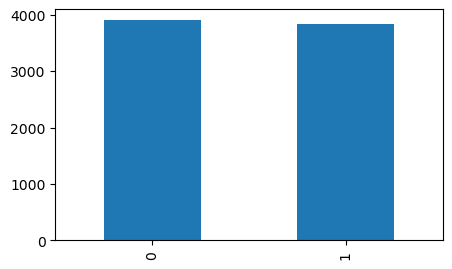

In [5]:
df["is_depression"].value_counts().plot(kind="bar",figsize=(5,3))

In [6]:
# Cek apakah terdapat null value atau tidak.
print(df.isnull().sum())

text             0
is_depression    0
text_id          0
dtype: int64


In [7]:
# Cek tipe data kolom.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           7731 non-null   object
 1   is_depression  7731 non-null   int64 
 2   text_id        7731 non-null   object
dtypes: int64(1), object(2)
memory usage: 181.3+ KB
None


# Memproses Data Teks

In [8]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

# def translate_text(text):
#     url = "https://translate.googleapis.com/translate_a/single?client=gtx&sl=en&tl=id&dt=t&q={}".format(text)
#     response = requests.get(url)
#     result = response.json()[0][0][0]
#     return result

def preprocess_text(text):
#     text = translate_text(text) # Kemudian di sini kita coba translate
    text = word_tokenize(text.lower()) # Tokenize text_id ke dalam token/kata
    text = [t for t in text if t not in stop_words] # Hapus stop_words
    text = [stemmer.stem(t) for t in text] # Menjadikan kata dasar
    text = [t if not t.isdigit() else num2words(int(t)) for t in text] # Mengganti angka ke teks
#     text = emoji.demojize(text) # ubah emoji ke dalam bentuk teks
#     text = re.sub(r':[a-z_]+:', lambda m: ' '.join(m.group(0).replace(':', '').split('_')), text) # Regex misal emoji: 🎉 bakal diubah jadi "party popper".
    text = ' '.join(text) # Gabungkan ke dalam teks kembali
    return text

In [9]:
df = df[pd.notnull(df['text_id'])] # hapus semua baris dengan nilai NaN di kolom `text`
df = df[df['text_id'].apply(lambda x: isinstance(x, str))] # hapus semua baris di mana `text` bukan string
df['nlp_text'] = df['text_id'].apply(lambda x: preprocess_text(x))

In [10]:
df.head()

,text,is_depression,text_id,nlp_text
0,we understand that most people who reply immed...,1,Kami memahami bahwa kebanyakan orang yang sege...,paham banyak orang balas op undang bicara prib...
1,welcome to r depression s check in post a plac...,1,Selamat datang di post Depresi S Posting di te...,selamat post depresi s posting ambil bagi mili...
2,anyone else instead of sleeping more when depr...,1,orang lain daripada lebih banyak tidur ketika ...,orang tidur depresi begadang malam hindar cepa...
3,i ve kind of stuffed around a lot in my life d...,1,Saya telah banyak mengisi banyak dalam hidup s...,isi hidup tunda orang hindar orang dewasa tang...
4,sleep is my greatest and most comforting escap...,1,Tidur adalah pelarian terbesar dan paling meng...,tidur lari besar hibur kali bangun emosi rasa...


# Hitung *Unique Words*
Menghitung unique words untuk menghitung ukuran *vocabulary*.

In [11]:
words = set(word for sentence in df["nlp_text"] for word in sentence.split())
vocab_size = len(words)
print(vocab_size)

14233


# One Hot Representation dari Setiap Kalimat

In [12]:
one_hot_representation = [one_hot(words,vocab_size) for words in df["nlp_text"]]
# one_hot_representation

Cari panjang maksimum untuk dimasukan ke dalam word embeddings.

In [13]:
max_len = 0
for elem in one_hot_representation:
    if len(elem) > max_len:
        max_len = len(elem)
max_len

1300

# Converting one hot encodings to word embeddings

In [14]:
embedded_docs = pad_sequences(one_hot_representation, padding='pre', maxlen = max_len)

In [15]:
embedding_vector_features = max_len * 2
model = Sequential()
model.add(Embedding(14233, embedding_vector_features, input_length=max_len))
model.add((LSTM(100)))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer = 'adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1300, 2600)        37005800  
                                                                 
 lstm (LSTM)                 (None, 100)               1080400   
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 38,086,301
Trainable params: 38,086,301
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
y = df["is_depression"]

In [17]:
print(f"Shape of y is: {y.shape}")
print(f"Shape of embedded document is: {embedded_docs.shape}")

Shape of y is: (7731,)
Shape of embedded document is: (7731, 1300)


# Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(embedded_docs, y, test_size = 0.1, random_state = 42, stratify = y)

In [19]:
print(f"Shape of X train is: {X_train.shape}")
print(f"Shape of y train is: {y_train.shape}")
print(f"Shape of X test is: {X_test.shape}")
print(f"Shape of y test is: {y_test.shape}")

Shape of X train is: (6957, 1300)
Shape of y train is: (6957,)
Shape of X test is: (774, 1300)
Shape of y test is: (774,)


In [20]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=16) # Kayanya epoch cukup di 3 aja

#### Kalau ga cukup coba pakai chunking
# chunk_size = 1000  # set the size of each chunk
# # shuffle the data
# X_train, Y_train = shuffle(X_train, Y_train)
# # loop through the data in chunks
# for i in range(0, len(X_train), chunk_size):
#     X_chunk = X_train[i:i+chunk_size]
#     Y_chunk = Y_train[i:i+chunk_size]  
#     # train the model on the current chunk
#     model.fit(X_chunk, Y_chunk, epochs=1, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/5
435/435 [==============================] - 76s 160ms/step - loss: 0.1733 - accuracy: 0.9366 - val_loss: 0.1107 - val_accuracy: 0.9638
Epoch 2/5
435/435 [==============================] - 44s 100ms/step - loss: 0.0679 - accuracy: 0.9715 - val_loss: 0.1161 - val_accuracy: 0.9625
Epoch 3/5
435/435 [==============================] - 39s 90ms/step - loss: 0.0323 - accuracy: 0.9871 - val_loss: 0.1559 - val_accuracy: 0.9470
Epoch 4/5
435/435 [==============================] - 37s 86ms/step - loss: 0.0189 - accuracy: 0.9931 - val_loss: 0.1905 - val_accuracy: 0.9535
Epoch 5/5
435/435 [==============================] - 38s 87ms/step - loss: 0.0142 - accuracy: 0.9945 - val_loss: 0.2225 - val_accuracy: 0.9406


In [21]:
y_pred = model.predict(X_test)

25/25 [==============================] - 1s 42ms/step


Probability greater than or equal to 0.5 will be assigned to the positive class.

In [22]:
y_pred = (y_pred >= 0.5).astype("int")

In [23]:
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       390
           1       0.93      0.95      0.94       384

    accuracy                           0.94       774
   macro avg       0.94      0.94      0.94       774
weighted avg       0.94      0.94      0.94       774

[[363  27]
 [ 19 365]]


In [24]:
y_test = y_test.reset_index(drop = True).values # Reset index `y_test` supaya dari 0 lagi sebelum dikonversi ke dalam array

In [25]:
# model.save('model.h5')

In [26]:
### Belum selesai
# from keras.models import load_model

# model = load_model('model.h5')

# # Take user input from the command line
# text = input("Enter your text: ")

# # Tokenize and preprocess the text (use the same preprocessing steps as in training)
# preprocessed_text = preprocess(text)

# # Convert preprocessed text to a numpy array
# X = np.array([preprocessed_text])

# # Make predictions using your trained model
# y_pred_prob = model.predict(X)
# y_pred = np.argmax(y_pred_prob, axis=1)

# # Print the predicted label (0 or 1)
# print("Predicted label: {}".format(y_pred[0]))

In [27]:
for i in range(len(y_test)):
    print("True label: {}, Predicted label: {}".format(y_test[i], y_pred[i]))

True label: 0, Predicted label: [0]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 0, Predicted label: [0]
True label: 1, Predicted label: [0]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 0, Predicted label: [0]
True label: 0, Predicted label: [0]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 0, Predicted label: [0]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 1, Predicted label: [1]
True label: 1, Predicted label: [1]
True label: 0, Predicted label: [0]
True label: 1, Predicted lab